# Présentation du projet développer un VAE pour générer des images

![Texte alternatif](vae.png)

## Les étapes du projet


1. **Collecte de données** :
   - Téléchargez et préparez la base de données "CelebA Faces". Assurez-vous d'avoir un ensemble d'images de visages de célébrités pour former votre modèle VAE.

2. **Prétraitement des données** :
   - Réduisez la taille des images si nécessaire.
   - Normalisez les pixels des images.
   - Divisez les données en ensembles d'entraînement et de test.

3. **Création de l'Architecture VAE** :
   - Définissez l'architecture du Variational Autoencoder, y compris l'encodeur et le décodeur.
   - L'encodeur comprime les images d'entrée en des représentations latentes.
   - Le décodeur génère de nouvelles images à partir de ces représentations.

4. **Fonction de Perte (Loss Function)** :
   - Mise en place d'une fonction de perte personnalisée pour le VAE, comprenant à la fois une perte de reconstruction et une perte de divergence KL (Kullback-Leibler).
   - La perte de reconstruction mesure la précision de la génération d'images.
   - La perte KL encourage la distribution des représentations latentes à se rapprocher d'une distribution normale.

5. **Entraînement du VAE** :
   - Entraînez votre modèle VAE sur l'ensemble d'entraînement "CelebA Faces".
   - Surveillez la perte pendant l'entraînement et ajustez les hyperparamètres si nécessaire.

6. **Génération d'Images** :
   - Une fois le modèle VAE entraîné, utilisez-le pour générer de nouvelles images de visages de célébrités.
   - Vous pouvez échantillonner des points dans l'espace latent pour générer différents visages.

7. **Évaluation** :
   - Évaluez la qualité des images générées par votre VAE. Vous pouvez utiliser des métriques telles que la similarité structurelle (SSIM) ou des évaluations visuelles.

8. **Affichage des Résultats** :
   - Affichez les visages de célébrités générés par votre modèle.
   - Créez une grille d'images pour visualiser les résultats.

9. **Optimisation et Itérations** :
   - Vous pouvez itérer sur l'entraînement, l'architecture et les hyperparamètres pour améliorer la qualité des images générées.

Ce projet est une excellente opportunité pour explorer l'apprentissage profond, la génération d'images et les VAE tout en utilisant une base de données de visages de célébrités populaires. Il vous permettra d'acquérir des compétences en vision par ordinateur et en réseaux de neurones.


## Base de Données - CelebA Faces


La base de données "CelebA Faces" est l'un des ensembles de données les plus populaires pour la reconnaissance faciale et la génération d'images de célébrités. Elle comprend un vaste ensemble d'images haute résolution de visages de célébrités provenant de diverses sources. Vous pouvez télécharger la base de données depuis le site officiel de CelebA.

- **Site Web Officiel de CelebA** : [CelebA Dataset], (http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) vous pouvez télécharger la base de données sur Kaggle en cliquant [ici](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)

Elle comprend un vaste ensemble d'images haute résolution de visages de célébrités provenant de diverses sources. Voici quelques caractéristiques clés de la base de données "CelebA Faces" :

- **Taille de la Base de Données** : La base de données "CelebA Faces" contient des centaines de milliers d'images de visages de célébrités.

- **Diversité des Visages** : Vous trouverez des images de célébrités de différents âges, ethnies et styles de coiffure, ce qui en fait une ressource précieuse pour la génération d'images diverses.

- **Annotations** : Chaque image est accompagnée d'annotations, telles que les coordonnées des yeux, le genre de la célébrité, etc. Ces annotations peuvent être utiles pour diverses tâches de traitement d'images.

- **Format des Images** : Les images de "CelebA Faces" sont généralement de haute résolution et en couleur, au format JPG.


Avant de commencer votre projet, assurez-vous de télécharger et de préparer la base de données "CelebA Faces". Elle sera la source de données essentielle pour l'entraînement de votre Variational Autoencoder (VAE) visant à générer de nouveaux visages de célébrités. Cliquez [ici](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) pour télécharger.


# Importation des packages

In [121]:
# Chargement de l'extension autoreload pour mettre à jour automatiquement le code
%load_ext autoreload
%autoreload 2

# Importation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

# Importation de fonctions personnalisées depuis les fichiers locaux
from notebooks.utils import sample_batch, display
from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'notebooks'

# Paramètres du projet <a name="parameters"></a>

In [56]:
# Taille des images en pixels
IMAGE_SIZE = 64
# Nombre de canaux de couleur (3 pour les images en couleur, 1 pour les images en noir et blanc)
CHANNELS = 3
# Taille du lot d'entraînement (nombre d'images dans chaque lot)
BATCH_SIZE = 128
# Nombre de caractéristiques dans l'espace latent
NUM_FEATURES = 64
# Dimension de l'espace latent (représentation latente des données)
Z_DIM = 200
# Taux d'apprentissage du modèle
LEARNING_RATE = 0.0005
# Nombre d'époques d'entraînement
EPOCHS = 10
# Paramètre de régularisation (facteur de la divergence KL dans la perte VAE)
BETA = 2000
# Option pour charger un modèle pré-entraîné (True pour charger, False pour entraîner à partir de zéro)
LOAD_MODEL = False


In [57]:
# Définissez le chemin complet
data_dir = "lien vers le dossier de travail avec les données"


## Préparation des données<a name="prepare"></a>

In [58]:

# Charger les données en utilisant la variable du chemin d'accès
train_data = utils.image_dataset_from_directory(
    data_dir + "/img_align_celeba",  # Concaténer data_dir avec "/img_align_celeba" pour obtenir le chemin complet
    labels=None,                    # Aucune étiquette n'est utilisée
    color_mode="rgb",               # Mode couleur RVB
    image_size=(IMAGE_SIZE, IMAGE_SIZE),  # Taille des images
    batch_size=BATCH_SIZE,           # Taille du lot
    shuffle=True,                   # Mélanger les données
    seed=42,                        # Graine pour la reproductibilité
    interpolation="bilinear"        # Méthode d'interpolation pour le redimensionnement
)


Found 202599 files belonging to 1 classes.


In [59]:
# Prétraitement des données
def preprocess(img):
    """
    Normalise une image en convertissant ses valeurs en flottant et les mettant à l'échelle entre 0 et 1.

    Args:
        img (tf.Tensor): L'image à prétraiter.

    Returns:
        img (tf.Tensor): L'image normalisée.
    """
    # Conversion des valeurs de l'image en flottant et mise à l'échelle entre 0 et 1
    img = tf.cast(img, "float32") / 255.0
    return img

# Application de la fonction de prétraitement aux données d'entraînement
train = train_data.map(lambda x: preprocess(x))


In [122]:
# Échantillonne un lot de données à partir de l'ensemble de données d'entraînement
train_sample = sample_batch(train)

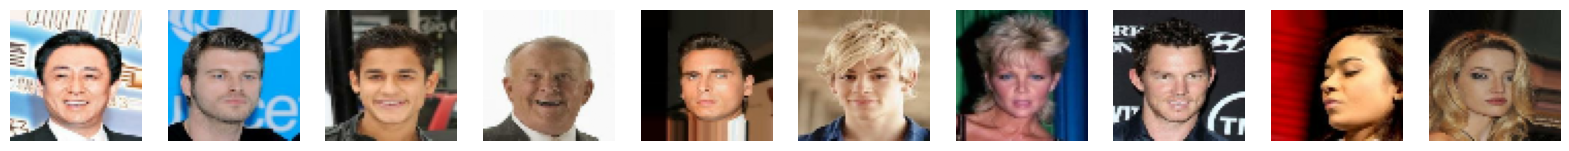

In [125]:
# Affiche quelques visages de l'ensemble d'entraînement
display(train_sample, cmap=None)


## Construction du Variational Autoencoder <a name="build"></a>

In [62]:
# Classe de couche personnalisée pour l'échantillonnage dans le VAE
class Sampling(layers.Layer):
    def call(self, inputs):
        """
        Effectue l'échantillonnage pour générer des échantillons à partir des moyennes et des log-variances latentes.

        Args:
            inputs (tuple): Un tuple contenant les tenseurs z_mean et z_log_var.

        Returns:
            z (tf.Tensor): Le tenseur résultant de l'échantillonnage.
        """
        # Extraction des moyennes et des log-variances
        z_mean, z_log_var = inputs

        # Obtention de la taille du lot (batch) et de la dimension latente
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]

        # Génération d'un échantillon epsilon à partir d'une distribution normale
        epsilon = K.random_normal(shape=(batch, dim))

        # Calcul de l'échantillon z en utilisant les moyennes, les log-variances et epsilon
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon

        return z

In [63]:
# Définition de l'entrée du modèle d'encodage
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)

# Construction des couches de convolution et de normalisation
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Ajout de couches de convolution, de normalisation et de ReLU supplémentaires
# Cela permet d'apprendre des caractéristiques à différentes échelles
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Aplatit les activations en un vecteur
x = layers.Flatten()(x)

# Projection des activations dans l'espace latent (z_mean et z_log_var)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)

# Utilisation de la classe personnalisée Sampling pour l'échantillonnage
z = Sampling()([z_mean, z_log_var])

# Création du modèle d'encodage
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

# Affichage du résumé du modèle d'encodage
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 32, 32, 64)           1792      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization_22 (Ba  (None, 32, 32, 64)           256       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_22 (LeakyReLU)  (None, 32, 32, 64)           0         ['batch_normalization_22

In [64]:
# Décodeur
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")

# Projection des activations latentes dans l'espace avant l'aplatissement
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Rétablissement de la forme avant l'aplatissement
x = layers.Reshape(shape_before_flattening)(x)

# Utilisation de couches de déconvolution pour générer une sortie
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

# Couche de sortie pour générer l'image décodée
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)

# Création du modèle de décodage
decoder = models.Model(decoder_input, decoder_output)

# Affichage du résumé du modèle de décodage
decoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense_2 (Dense)             (None, 256)               51456     
                                                                 
 batch_normalization_27 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 256)               0         
                                                                 
 reshape_2 (Reshape)         (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose_12 (Conv2  (None, 4, 4, 64)          36928     
 DTranspose)                                               

In [ ]:
tf.keras.utils.plot_model(decoder)

In [65]:
# Classe VAE (Variational Autoencoder)
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        """
        Initialise un modèle Variational Autoencoder (VAE).

        Args:
            encoder (tf.keras.models.Model): Le modèle de l'encodeur.
            decoder (tf.keras.models.Model): Le modèle du décodeur.
            **kwargs: Arguments supplémentaires pour la classe parente.
        """
        super(VAE, self).__init__(**kwargs)
        
        # Initialisation de l'encodeur et du décodeur
        self.encoder = encoder
        self.decoder = decoder
        
        # Création de traqueurs pour les métriques
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        """
        Métriques à surveiller pendant l'entraînement.

        Returns:
            list: Liste de métriques à surveiller.
        """
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """
        Appelle le modèle sur une entrée particulière.

        Args:
            inputs: Les données d'entrée.

        Returns:
            tuple: Un tuple contenant les moyennes latentes, les log-variances latentes et les reconstructions.
        """
        # Appel de l'encodeur et du décodeur
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """
        Étape exécutée lors de l'entraînement.

        Args:
            data: Les données d'entraînement.

        Returns:
            dict: Un dictionnaire contenant les métriques de perte.
        """
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            
            # Calcul de la perte de reconstruction
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            
            # Calcul de la perte de divergence de Kullback-Leibler (KL)
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            
            # Calcul de la perte totale
            total_loss = reconstruction_loss + kl_loss

        # Calcul des gradients et mise à jour des poids
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Mise à jour des métriques
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """
        Étape exécutée lors de la validation.

        Args:
            data: Les données de validation.

        Returns:
            dict: Un dictionnaire contenant les métriques de perte.
        """
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        
        # Calcul de la perte de reconstruction
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        
        # Calcul de la perte de divergence de Kullback-Leibler (KL)
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        
        # Calcul de la perte totale
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [66]:
# Créer un Variational Autoencoder (VAE)
vae = VAE(encoder, decoder)

# Entrainer le modèle <a name="train"></a>

In [67]:
# Compiler le Variational Autoencoder (VAE)
optimizer = optimizers.legacy.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)


In [68]:
# Créer un point de contrôle pour sauvegarder le modèle
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",  # Chemin pour sauvegarder les poids et le modèle complet
    save_weights_only=False,  # Sauvegarder le modèle complet, pas seulement les poids
    save_freq="epoch",  # Sauvegarder à chaque fin d'époque
    monitor="loss",  # Surveiller la perte d'entraînement
    mode="min",  # Minimiser la perte
    save_best_only=True,  # Ne sauvegarder que le meilleur modèle
    verbose=0,  # Désactiver les messages verbeux
)

# Créer un rappel TensorBoard pour la journalisation
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Créer une classe de rappel pour générer des images
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        """
        Initialise un rappel pour générer des images.

        Args:
            num_img (int): Le nombre d'images à générer à chaque fin d'époque.
            latent_dim (int): La dimension latente des vecteurs de bruit.
        """
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        """
        Méthode appelée à la fin de chaque époque pour générer des images.

        Args:
            epoch (int): Le numéro de l'époque actuelle.
            logs (dict): Les journaux d'entraînement (non utilisés ici).
        """
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))


In [69]:
# Charger d'anciens poids du modèle si nécessaire
if LOAD_MODEL:
    vae.load_weights("./models/vae")  # Charger les poids du modèle VAE depuis le fichier
    tmp = vae.predict(train.take(1))  # Effectuer une prédiction de test avec le modèle chargé


In [70]:
# Entraîner le modèle VAE sur l'ensemble d'entraînement
vae.fit(
    train,  # Utiliser l'ensemble de données d'entraînement
    epochs=EPOCHS,  # Nombre d'époques d'entraînement
    callbacks=[  # Liste des rappels à utiliser pendant l'entraînement
        model_checkpoint_callback,  # Sauvegarder les poids du modèle à chaque époque
        tensorboard_callback,  # Journalisation pour TensorBoard
        ImageGenerator(num_img=10, latent_dim=Z_DIM),  # Générer des images à la fin de chaque époque
    ],
)


Epoch 1/10
1583/1583 [==============================] - ETA: 0s - loss: 102.9863 - reconstruction_loss: 69.4113 - kl_loss: 15.1639WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 483s 305ms/step - loss: 102.9746 - reconstruction_loss: 69.4113 - kl_loss: 15.1639
Epoch 2/10
1583/1583 [==============================] - ETA: 0s - loss: 71.9071 - reconstruction_loss: 55.5037 - kl_loss: 15.2161WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 478s 302ms/step - loss: 71.9063 - reconstruction_loss: 55.5037 - kl_loss: 15.2161
Epoch 3/10
1583/1583 [==============================] - ETA: 0s - loss: 68.3905 - reconstruction_loss: 51.7434 - kl_loss: 16.0926WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 477s 301ms/step - loss: 68.3901 - reconstruction_loss: 51.7434 - kl_loss: 16.0926
Epoch 4/10
1583/1583 [==============================] - ETA: 0s - loss: 66.7059 - reconstruction_loss: 49.9782 - kl_loss: 16.4463WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 480s 303ms/step - loss: 66.7057 - reconstruction_loss: 49.9782 - kl_loss: 16.4463
Epoch 5/10
1583/1583 [==============================] - ETA: 0s - loss: 65.8805 - reconstruction_loss: 49.0150 - kl_loss: 16.6741WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 482s 304ms/step - loss: 65.8804 - reconstruction_loss: 49.0150 - kl_loss: 16.6741
Epoch 6/10
1583/1583 [==============================] - ETA: 0s - loss: 65.3374 - reconstruction_loss: 48.3787 - kl_loss: 16.8199WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 483s 305ms/step - loss: 65.3373 - reconstruction_loss: 48.3787 - kl_loss: 16.8199
Epoch 7/10
1583/1583 [==============================] - ETA: 0s - loss: 65.0140 - reconstruction_loss: 47.9767 - kl_loss: 16.8927WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 494s 312ms/step - loss: 65.0139 - reconstruction_loss: 47.9767 - kl_loss: 16.8927
Epoch 8/10
1583/1583 [==============================] - ETA: 0s - loss: 64.7078 - reconstruction_loss: 47.6258 - kl_loss: 16.9756WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 476s 301ms/step - loss: 64.7077 - reconstruction_loss: 47.6258 - kl_loss: 16.9756
Epoch 9/10
1583/1583 [==============================] - ETA: 0s - loss: 64.5153 - reconstruction_loss: 47.3505 - kl_loss: 17.0682WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 472s 298ms/step - loss: 64.5153 - reconstruction_loss: 47.3505 - kl_loss: 17.0682
Epoch 10/10
1583/1583 [==============================] - ETA: 0s - loss: 64.3321 - reconstruction_loss: 47.1271 - kl_loss: 17.0969WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


1583/1583 [==============================] - 474s 299ms/step - loss: 64.3321 - reconstruction_loss: 47.1271 - kl_loss: 17.0969


In [71]:
# Sauvegarder les modèles finaux
vae.save("./models/vae")  # Sauvegarder le modèle VAE complet
encoder.save("./models/encoder")  # Sauvegarder le modèle d'encodeur
decoder.save("./models/decoder")  # Sauvegarder le modèle de décodeur


[autoreload of vae_utils failed: Traceback (most recent call last):
  File "/Users/natachanjongwayepnga/anaconda3/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/Users/natachanjongwayepnga/anaconda3/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/Users/natachanjongwayepnga/anaconda3/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/natachanjongwayepnga/30DaysGenerativeAI/JOUR8/Faces/vae_utils.py", line 205
   

INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


##  Reconstruire en utilisant l'autoencodeur variationnel <a name="reconstruct"></a>

In [143]:
# Sélectionner un sous-ensemble de l'ensemble de test
batches_to_predict = 1  # Nombre de lots (batches) à prédire
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)


4/4 [==============================] - 0s 35ms/step
Exemples de vrais visages


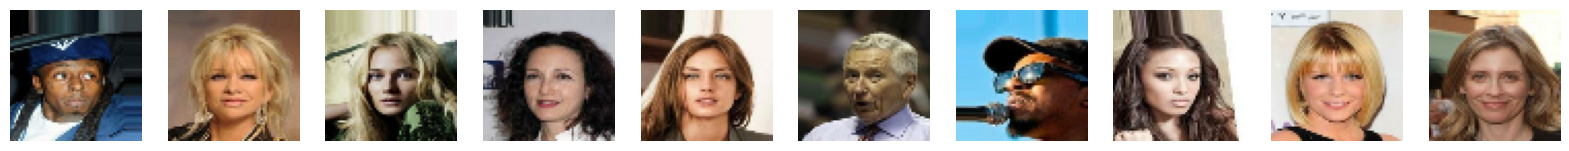

Reconstructions


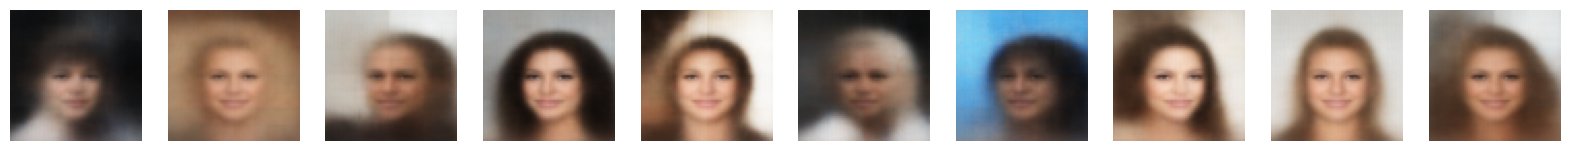

In [144]:
# Créer des prédictions de l'autoencodeur et les afficher
z_mean, z_log_var, reconstructions = vae.predict(example_images)

# Afficher les vrais visages de l'exemple
print("Exemples de vrais visages")
display(example_images)

# Afficher les reconstructions
print("Reconstructions")
display(reconstructions)


##  Distribution de l'espace latent

4/4 [==============================] - 0s 9ms/step


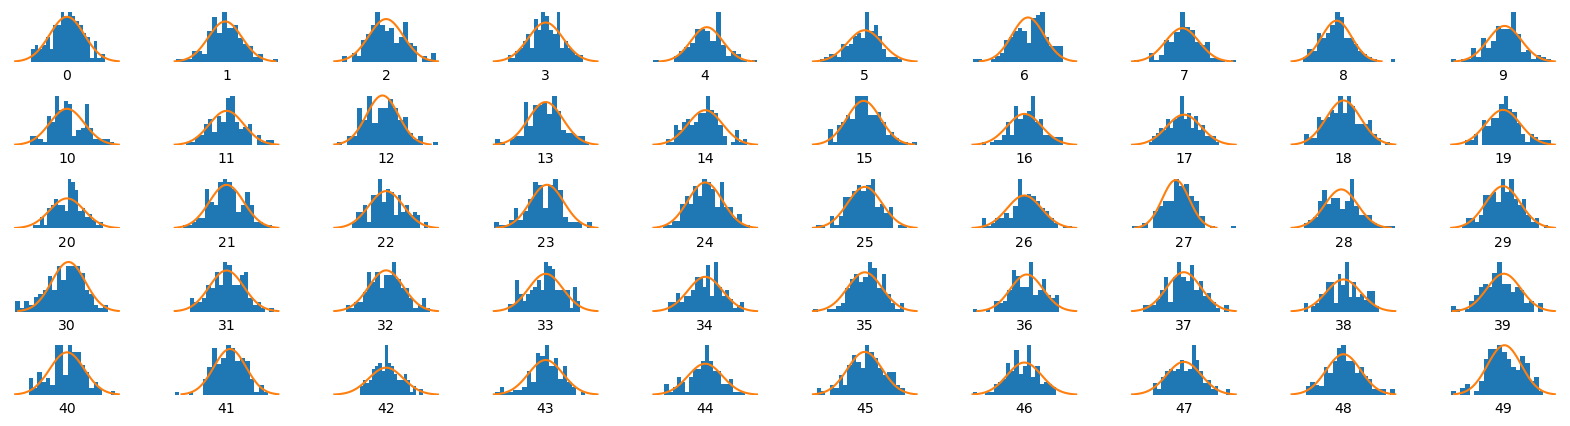

In [145]:
_, _, z = vae.encoder.predict(example_images)  # Obtenir les vecteurs de l'espace latent pour les images d'exemple

x = np.linspace(-3, 3, 100)  # Créer une séquence de valeurs pour la distribution

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)  # Afficher un histogramme des valeurs de l'espace latent
    ax.axis("off")  # Désactiver les axes
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )  # Ajouter une étiquette pour l'index de la dimension latente
    ax.plot(x, norm.pdf(x))  # Tracer la distribution de probabilité attendue (normale)

plt.show()  # Afficher la figure


# Générer de nouveaux visages <a name="decode"></a>

In [149]:
# Échantillonner des points dans l'espace latent à partir de la distribution normale standard
grid_width, grid_height = (10, 3)  # Dimensions de la grille d'échantillonnage
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))  # Générer des échantillons aléatoires dans l'espace latent


In [150]:
# Décoder les points échantillonnés
reconstructions = decoder.predict(z_sample)


1/1 [==============================] - 0s 35ms/step


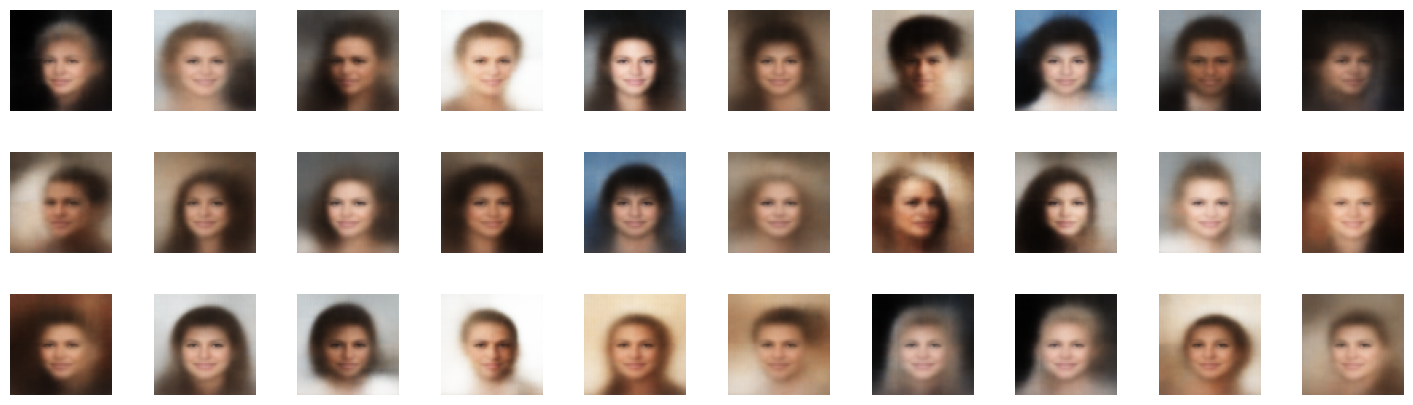

In [151]:
# Créer un graphique des images décodées
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Afficher la grille des visages générés
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")  # Désactiver les axes
    ax.imshow(reconstructions[i, :, :])  # Afficher l'image décodée


# Modifier des images <a name="manipulate"></a>

In [159]:
# Charger l'ensemble de données d'étiquettes
attributes = pd.read_csv(data_dir + "/list_attr_celeba.csv")
print(attributes.columns)  # Afficher les noms des colonnes de l'ensemble de données
attributes.head()  # Afficher les premières lignes de l'ensemble de données


Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1          1                -1           -1                -1   
3              1         -1                 1           -1                 1   
4             -1         -1                -1           -1                 1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                 1               -1      1  
4                -1               -1      1  

[5 rows x 41 columns]

In [160]:
# Charger les données de visages avec les étiquettes associées
LABEL = "Smiling"  # <- Définissez cette étiquette
labelled_test = utils.image_dataset_from_directory(
    data_dir + "/img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

# Prétraiter les données d'images et d'étiquettes
labelled = labelled_test.map(lambda x, y: (preprocess(x), y))


Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


In [161]:
# Trouver le vecteur d'attribut
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)


label: Smiling
images : POS move : NEG move :distance : 𝛥 distance
59    : 1.95    : 1.615    : 2.441    : 2.441
120    : 1.397    : 1.058    : 1.852    : -0.59
182    : 0.716    : 0.718    : 1.521    : -0.33
236    : 0.426    : 0.532    : 1.351    : -0.17
299    : 0.426    : 0.378    : 1.212    : -0.139
364    : 0.317    : 0.286    : 1.131    : -0.08
424    : 0.28    : 0.277    : 1.074    : -0.058
490    : 0.253    : 0.224    : 0.986    : -0.088
547    : 0.204    : 0.185    : 0.934    : -0.052
605    : 0.182    : 0.179    : 0.873    : -0.061
664    : 0.15    : 0.167    : 0.852    : -0.021
721    : 0.15    : 0.157    : 0.812    : -0.04
776    : 0.142    : 0.15    : 0.79    : -0.022
834    : 0.139    : 0.115    : 0.753    : -0.037
890    : 0.129    : 0.115    : 0.735    : -0.018
957    : 0.125    : 0.097    : 0.74    : 0.004
1025    : 0.112    : 0.1    : 0.726    : -0.014
1092    : 0.102    : 0.1    : 0.707    : -0.019
1155    : 0.096    : 0.096    : 0.705    : -0.003
1202    : 0.091   

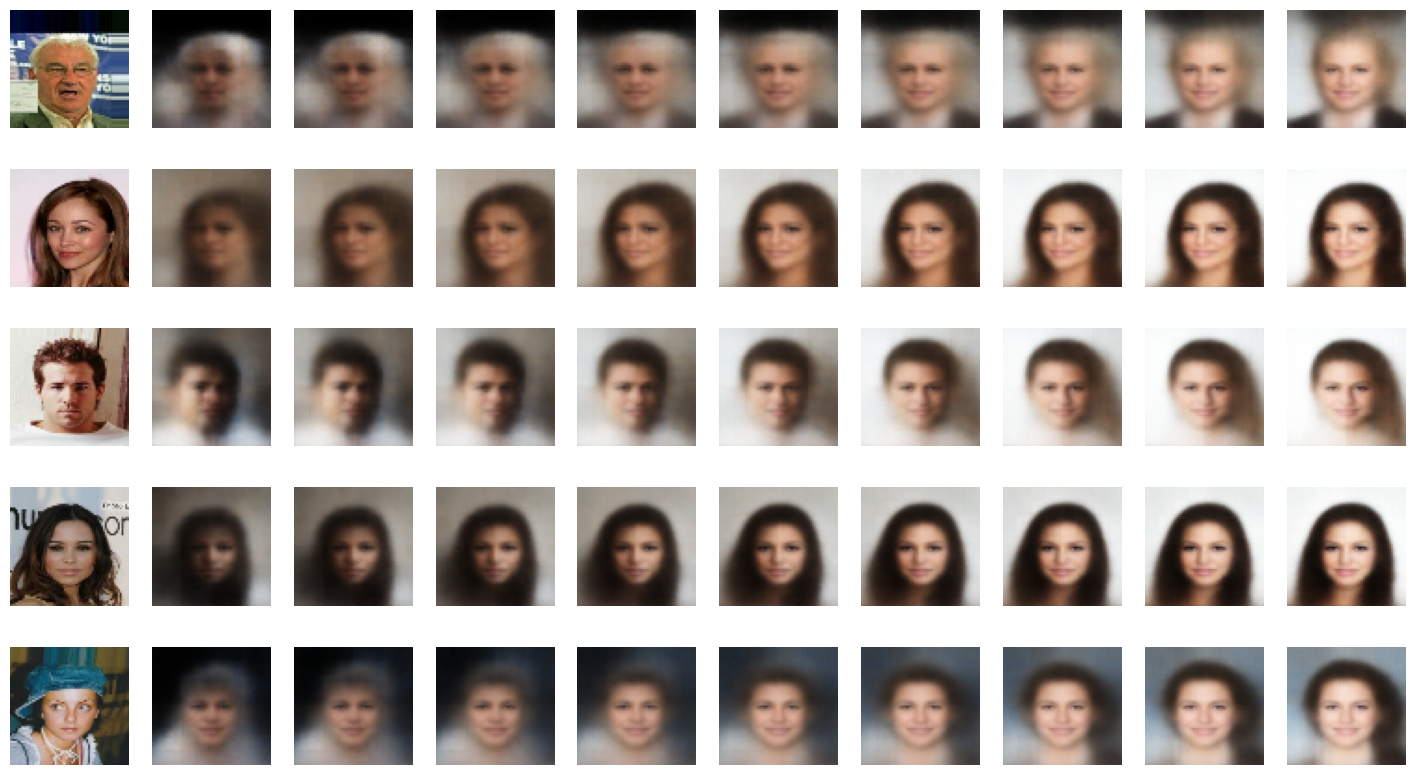

In [167]:
# Ajouter le vecteur aux images
add_vector_to_images(labelled, vae, attribute_vec)


In [ ]:
# Créer une interpolation entre deux images en fonction de facteurs
morph_faces(labelled, vae)

In [168]:
# Charger les données de visages avec les étiquettes associées
LABEL = "Blond_Hair"  # <- Définissez cette étiquette
labelled_test = utils.image_dataset_from_directory(
    data_dir + "/img_align_celeba",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

# Prétraiter les données d'images et d'étiquettes
labelled = labelled_test.map(lambda x, y: (preprocess(x), y))


Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


In [169]:
# Trouver le vecteur d'attribut
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)


label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
22    : 3.204    : 1.431    : 3.449    : 3.449
44    : 2.038    : 0.97    : 2.754    : -0.695
65    : 1.208    : 0.592    : 2.278    : -0.475
87    : 0.843    : 0.412    : 2.114    : -0.164
110    : 0.666    : 0.274    : 1.951    : -0.163
128    : 0.483    : 0.216    : 1.924    : -0.027
150    : 0.462    : 0.203    : 1.873    : -0.051
171    : 0.375    : 0.204    : 1.796    : -0.076
197    : 0.384    : 0.158    : 1.759    : -0.037
218    : 0.287    : 0.144    : 1.709    : -0.051
241    : 0.286    : 0.136    : 1.686    : -0.023
260    : 0.219    : 0.116    : 1.68    : -0.006
282    : 0.225    : 0.11    : 1.654    : -0.027
302    : 0.227    : 0.099    : 1.617    : -0.037
317    : 0.179    : 0.094    : 1.619    : 0.002
337    : 0.199    : 0.091    : 1.612    : -0.008
356    : 0.166    : 0.081    : 1.588    : -0.023
377    : 0.183    : 0.076    : 1.56    : -0.028
395    : 0.159    : 0.074    : 1.543    : -0.017
415    : 

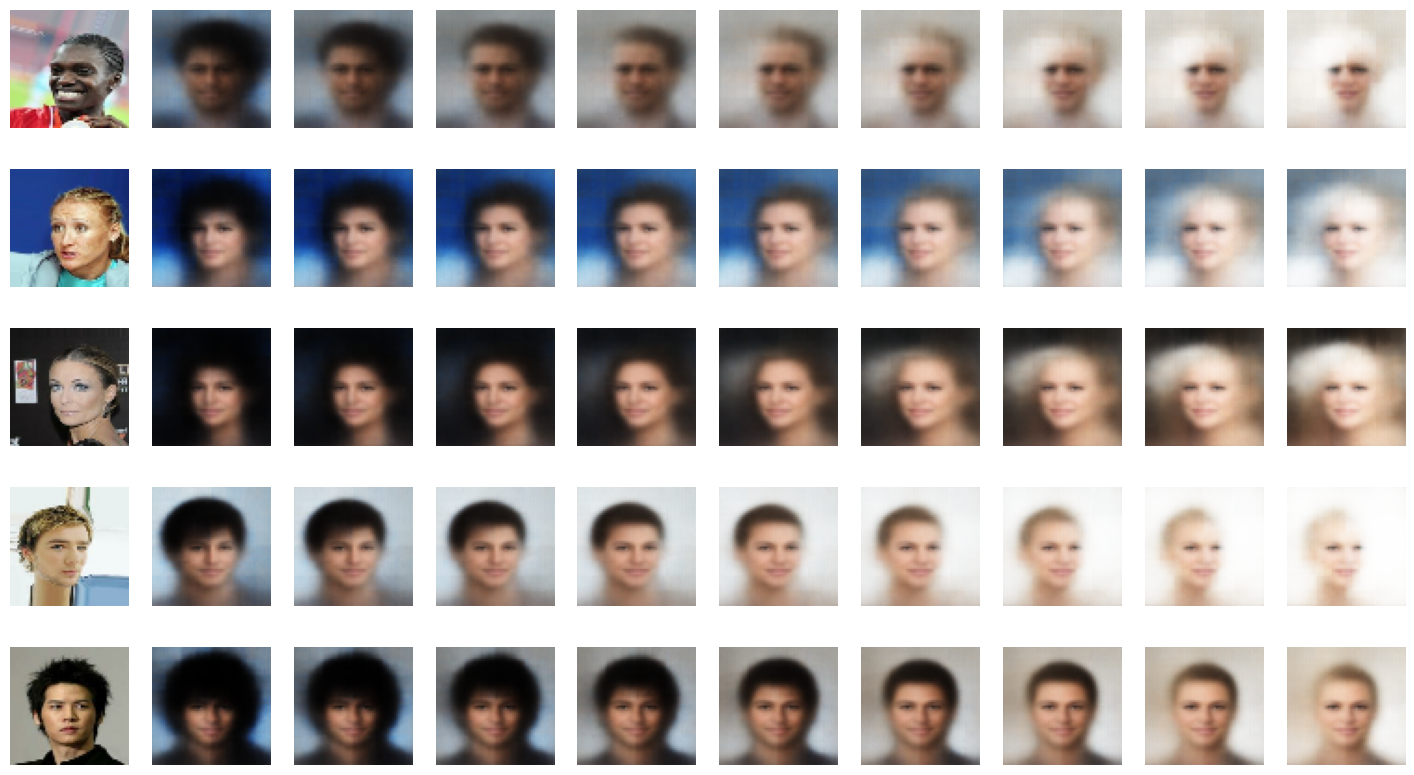

In [173]:
# Ajouter le vecteur aux images
add_vector_to_images(labelled, vae, attribute_vec)


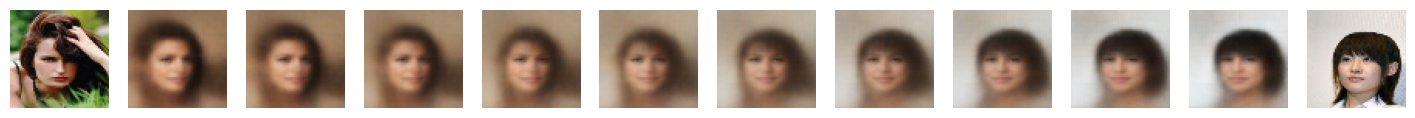

In [120]:
# Créer une interpolation entre deux images en fonction de facteurs
morph_faces(labelled, vae)
